# Sentiment Analysis on Product Reviews

This notebook covers the complete workflow for sentiment analysis on product reviews, including data loading, preprocessing, feature engineering, model training (classical ML, LSTM, BERT), and evaluation.

# 1. Data Loading and Preprocessing

This section loads the raw product reviews dataset, performs cleaning, removes duplicates, filters out neutral reviews, and creates binary sentiment labels.

In [13]:
import pandas as pd
import os
import time
import numpy as np

# Define correct paths (fix double 'data' and use forward slashes for cross-platform compatibility)
data_path = os.path.join('data', 'Reviews.csv')
output_path = os.path.join('data', 'preprocessed_reviews.csv')

if not os.path.exists(data_path):
    print(f'Error: Dataset file not found at {data_path}')
else:
    print(f'Loading dataset from: {data_path}')
    start_time = time.time()
    df = pd.read_csv(data_path, usecols=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
    print(f'Dataset loaded in {time.time() - start_time:.2f} seconds.')
    print(f'Initial shape: {df.shape}')
    
    # 1. Handle Missing Values
    df.dropna(subset=['Text', 'Score'], inplace=True)
    print(f"Shape after dropping rows with missing Text/Score: {df.shape}")
    
    # 2. Remove Duplicates
    initial_shape = df.shape
    df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep='first', inplace=True)
    print(f"Removed {initial_shape[0] - df.shape[0]} duplicate entries.")
    print(f"Shape after removing duplicates: {df.shape}")
    
    # 3. Filter out neutral reviews (Score = 3)
    df_filtered = df[df['Score'] != 3].copy()
    print(f"Shape after removing neutral reviews: {df_filtered.shape}")
    
    # 4. Create Sentiment Label
    df_filtered['Sentiment'] = df_filtered['Score'].apply(lambda x: 1 if x > 3 else 0)
    
    # 5. Select Relevant Columns
    df_final = df_filtered[['Text', 'Sentiment']].copy()
    print("\nPreprocessing complete.")
    print(f"Final dataset shape: {df_final.shape}")
    print("\nValue counts for Sentiment:")
    print(df_final['Sentiment'].value_counts())
    
    # Save the preprocessed data
    df_final.to_csv(output_path, index=False)
    print(f"Preprocessed data saved to: {output_path}")

Loading dataset from: data\Reviews.csv
Dataset loaded in 8.44 seconds.
Initial shape: (568454, 10)
Shape after dropping rows with missing Text/Score: (568454, 10)
Removed 174521 duplicate entries.
Shape after removing duplicates: (393933, 10)
Shape after removing neutral reviews: (364164, 10)

Preprocessing complete.
Final dataset shape: (364164, 2)

Value counts for Sentiment:
Sentiment
1    307056
0     57108
Name: count, dtype: int64
Preprocessed data saved to: data\preprocessed_reviews.csv


# 2. Feature Engineering

This section generates features for model training using three approaches: TF-IDF, Word2Vec, and BERT embeddings.

In [9]:
# --- TF-IDF Feature Engineering ---
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

preprocessed_file = os.path.join('data', 'preprocessed_reviews.csv')
output_dir = 'processed_data'
vectorizer_path = os.path.join(output_dir, 'tfidf_vectorizer.joblib')
X_train_path = os.path.join(output_dir, 'X_train.joblib')
X_test_path = os.path.join(output_dir, 'X_test.joblib')
y_train_path = os.path.join(output_dir, 'y_train.joblib')
y_test_path = os.path.join(output_dir, 'y_test.joblib')

os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(preprocessed_file)
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

joblib.dump(vectorizer, vectorizer_path)
joblib.dump(X_train_tfidf, X_train_path)
joblib.dump(X_test_tfidf, X_test_path)
joblib.dump(y_train, y_train_path)
joblib.dump(y_test, y_test_path)
print("TF-IDF features generated and saved.")

TF-IDF features generated and saved.


## 3. Model Training and Evaluation
### Logistic Regression, Naive Bayes, Random Forest, SVM, XGBoost, LSTM, BERT
Each model will be trained and evaluated. Results (accuracy, confusion matrix, classification report) will be displayed.

Logistic Regression Accuracy: 0.9294001345543915
              precision    recall  f1-score   support

           0       0.85      0.67      0.75     11422
           1       0.94      0.98      0.96     61411

    accuracy                           0.93     72833
   macro avg       0.90      0.82      0.85     72833
weighted avg       0.93      0.93      0.93     72833



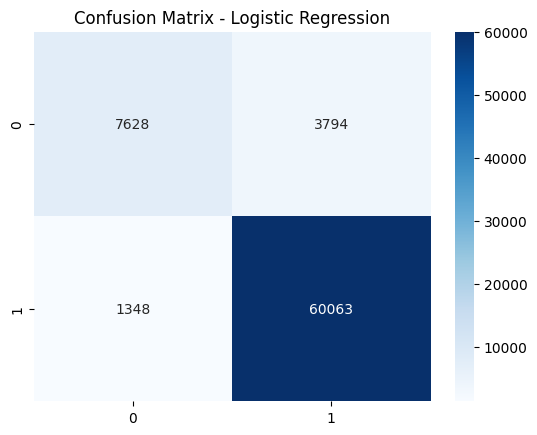

In [5]:
# --- Logistic Regression ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train = joblib.load(X_train_path)
X_test = joblib.load(X_test_path)
y_train = joblib.load(y_train_path)
y_test = joblib.load(y_test_path)

log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 2.1 Word2Vec Feature Engineering

Generate document embeddings using Word2Vec for each review. These features will be used for classical ML models.

In [10]:
from gensim.models import Word2Vec
import numpy as np

def tokenize(text):
    return str(text).lower().split()

df['tokens'] = df['Text'].apply(tokenize)
vector_size = 100
window = 5
min_count = 5
workers = 4
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers)
w2v_model_path = os.path.join(output_dir, 'word2vec_model.model')
w2v_model.save(w2v_model_path)
print(f"Word2Vec model saved to: {w2v_model_path}")

def document_vector(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

X_w2v = np.vstack([document_vector(tokens, w2v_model, vector_size) for tokens in df['tokens']])
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42, stratify=y)
import joblib
joblib.dump(X_train_w2v, os.path.join(output_dir, 'X_train_w2v.joblib'))
joblib.dump(X_test_w2v, os.path.join(output_dir, 'X_test_w2v.joblib'))
joblib.dump(y_train_w2v, os.path.join(output_dir, 'y_train_w2v.joblib'))
joblib.dump(y_test_w2v, os.path.join(output_dir, 'y_test_w2v.joblib'))
print("Word2Vec features generated and saved.")

Word2Vec model saved to: processed_data\word2vec_model.model
Word2Vec features generated and saved.


# 2.2 BERT Feature Engineering

Extract BERT embeddings for each review using a pre-trained BERT model. These features are suitable for advanced ML models.

In [11]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

sample_size = 1000  # Reduce for demo; increase for full run
df_bert = df.sample(n=min(sample_size, len(df)), random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

def get_bert_embedding(text, tokenizer, model, device):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:,0,:].cpu().numpy().flatten()

embeddings = []
for text in tqdm(df_bert['Text'], desc="Processing reviews"):
    embedding = get_bert_embedding(text, tokenizer, model, device)
    embeddings.append(embedding)
X_bert = np.vstack(embeddings)
y_bert = df_bert['Sentiment'].values
from sklearn.model_selection import train_test_split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42, stratify=y_bert)
import joblib
joblib.dump(X_train_bert, os.path.join(output_dir, 'X_train_bert.joblib'))
joblib.dump(X_test_bert, os.path.join(output_dir, 'X_test_bert.joblib'))
joblib.dump(y_train_bert, os.path.join(output_dir, 'y_train_bert.joblib'))
joblib.dump(y_test_bert, os.path.join(output_dir, 'y_test_bert.joblib'))
print("BERT features generated and saved.")

c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing reviews: 100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]

BERT features generated and saved.


# 3.1 Naive Bayes Classifier (TF-IDF)

Train and evaluate a Multinomial Naive Bayes classifier using TF-IDF features.

Naive Bayes Accuracy: 0.8957203465462085
              precision    recall  f1-score   support

           0       0.89      0.38      0.53     11422
           1       0.90      0.99      0.94     61411

    accuracy                           0.90     72833
   macro avg       0.90      0.69      0.74     72833
weighted avg       0.90      0.90      0.88     72833



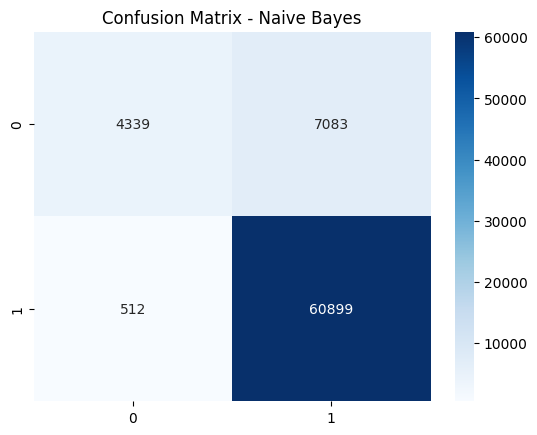

In [17]:
# --- Naive Bayes Classifier (TF-IDF) ---
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load TF-IDF features (not raw text!)
output_dir = 'processed_data'
X_train_path = os.path.join(output_dir, 'X_train.joblib')
X_test_path = os.path.join(output_dir, 'X_test.joblib')
y_train_path = os.path.join(output_dir, 'y_train.joblib')
y_test_path = os.path.join(output_dir, 'y_test.joblib')

X_train = joblib.load(X_train_path)
X_test = joblib.load(X_test_path)
y_train = joblib.load(y_train_path)
y_test = joblib.load(y_test_path)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# 3.2 Random Forest Classifier (TF-IDF)

Train and evaluate a Random Forest classifier using TF-IDF features.

Random Forest Accuracy: 0.9053862946741175
              precision    recall  f1-score   support

           0       0.86      0.48      0.61     11422
           1       0.91      0.99      0.95     61411

    accuracy                           0.91     72833
   macro avg       0.88      0.73      0.78     72833
weighted avg       0.90      0.91      0.89     72833



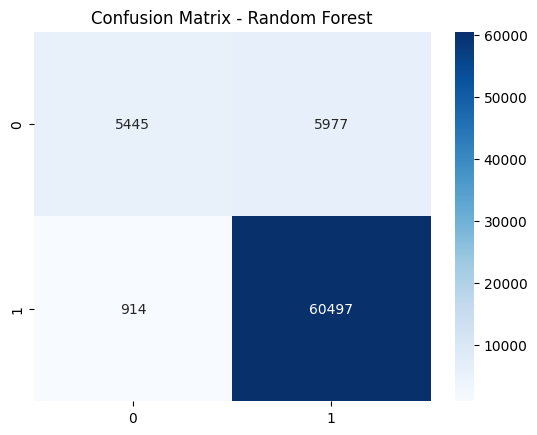

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# 3.3 SVM Classifier (TF-IDF)

Train and evaluate a Support Vector Machine classifier using TF-IDF features.

SVM Accuracy: 0.9299630661925227
              precision    recall  f1-score   support

           0       0.83      0.69      0.76     11422
           1       0.94      0.97      0.96     61411

    accuracy                           0.93     72833
   macro avg       0.89      0.83      0.86     72833
weighted avg       0.93      0.93      0.93     72833



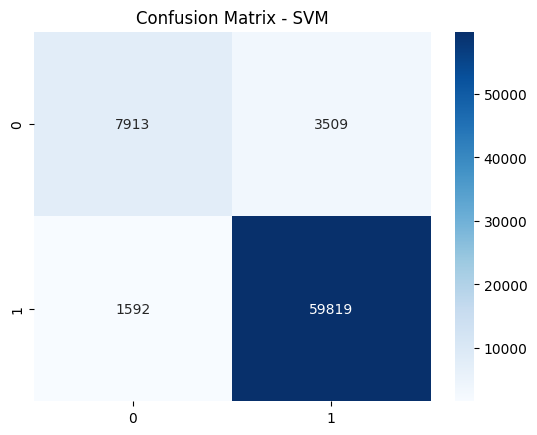

In [10]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
base_svm = LinearSVC(random_state=42, max_iter=1000, C=1.0)
svm_model = CalibratedClassifierCV(base_svm)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

# 3.4 XGBoost Classifier (TF-IDF)

Train and evaluate an XGBoost classifier using TF-IDF features.

c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:25:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9070888196284651
              precision    recall  f1-score   support

           0       0.85      0.49      0.62     11422
           1       0.91      0.98      0.95     61411

    accuracy                           0.91     72833
   macro avg       0.88      0.74      0.79     72833
weighted avg       0.90      0.91      0.90     72833



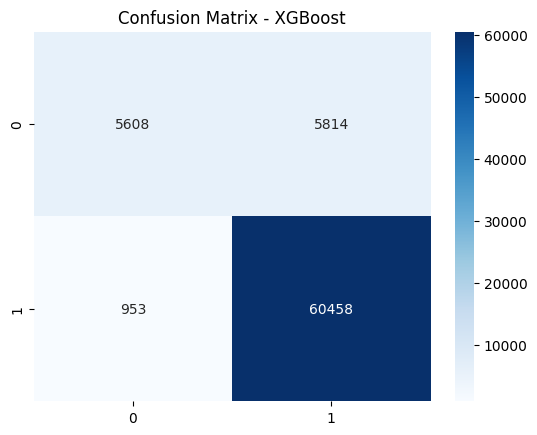

In [2]:
# --- XGBoost Classifier (TF-IDF) ---
import joblib
import os
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct paths for the TF-IDF features and labels
output_dir = 'processed_data'
X_train_path = os.path.join(output_dir, 'X_train.joblib')
X_test_path = os.path.join(output_dir, 'X_test.joblib')
y_train_path = os.path.join(output_dir, 'y_train.joblib')
y_test_path = os.path.join(output_dir, 'y_test.joblib')

X_train = joblib.load(X_train_path)
X_test = joblib.load(X_test_path)
y_train = joblib.load(y_train_path)
y_test = joblib.load(y_test_path)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# 3.5 LSTM Model (Deep Learning)

Train and evaluate an LSTM model using tokenized review sequences.

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import os

# Always load the preprocessed data to ensure 'Sentiment' column is present
preprocessed_file = os.path.join('data', 'preprocessed_reviews.csv')
df = pd.read_csv(preprocessed_file)

max_features = 10000
max_len = 200
all_words = []
for text in df['Text']:
    if isinstance(text, str):
        all_words.extend(text.lower().split())
word_counts = Counter(all_words)
most_common = word_counts.most_common(max_features-1)
vocab = {word: idx+1 for idx, (word, _) in enumerate(most_common)}
vocab['<UNK>'] = len(vocab) + 1

# Fix vocab_size to match the highest index in vocab
vocab_size = max(vocab.values()) + 1

def text_to_sequence(text, vocab, max_len):
    tokens = str(text).lower().split()
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

X_seq = np.array([text_to_sequence(text, vocab, max_len) for text in df['Text']])
y_seq = df['Sentiment'].values
from sklearn.model_selection import train_test_split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1, :, :]
        dense1 = torch.relu(self.fc1(hidden))
        drop = self.dropout(dense1)
        output = torch.sigmoid(self.fc2(drop))
        return output

embedding_dim = 128
hidden_dim = 128
output_dim = 1
dropout = 0.5
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

from torch.utils.data import TensorDataset, DataLoader

batch_size = 256

X_train_tensor = torch.LongTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(2):  # Use more epochs for real training
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

model.eval()
X_test_tensor = torch.LongTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = model(batch_X)
        preds = (preds > 0.5).float()
        correct += (preds == batch_y).float().sum().item()
        total += batch_y.size(0)
    acc = correct / total
    print(f"LSTM Test Accuracy: {acc:.4f}")

c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1, Loss: 0.4445
Epoch 2, Loss: 0.4349
Epoch 2, Loss: 0.4349
LSTM Test Accuracy: 0.8432
LSTM Test Accuracy: 0.8432


# 3.6 BERT Fine-tuning (Deep Learning)

Fine-tune a BERT model for sentiment classification using the Transformers library.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1
Train Loss: 0.4829, Train Accuracy: 0.8050
Train Loss: 0.4829, Train Accuracy: 0.8050
Val Loss: 0.4557, Val Accuracy: 0.8300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.83      1.00      0.91        83

    accuracy                           0.83       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.69      0.83      0.75       100

Val Loss: 0.4557, Val Accuracy: 0.8300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.83      1.00      0.91        83

    accuracy                           0.83       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.69      0.83      0.75       100



c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\OneDrive\Desktop\IIT Delhi\Major Project\Sentiment Analysis on Product Reviews\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

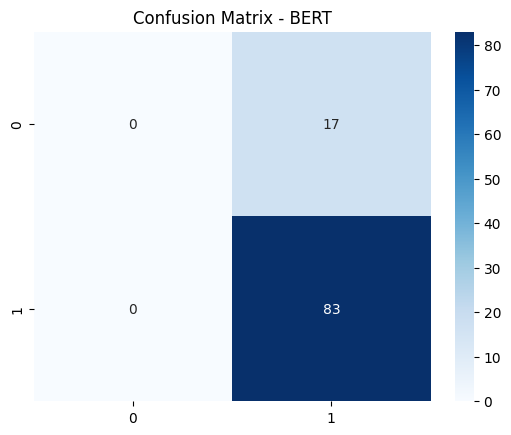

In [23]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx]) if self.texts[idx] else ""
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

sample_size = 500  # Reduce for demo; increase for full run
bert_df = df.sample(n=min(sample_size, len(df)), random_state=42)
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    bert_df['Text'].values, bert_df['Sentiment'].values, 
    test_size=0.2, random_state=42, stratify=bert_df['Sentiment']
)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1  # Use more epochs for real training
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        preds = torch.argmax(logits, dim=1)
        correct = (preds == labels).sum().item()
        total_loss += loss.item() * len(labels)
        total_correct += correct
        total_samples += len(labels)
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels).sum().item()
            total_loss += loss.item() * len(labels)
            total_correct += correct
            total_samples += len(labels)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy, all_preds, all_labels

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_dataloader, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    print(classification_report(val_labels, val_preds))
    cm_bert = confusion_matrix(val_labels, val_preds)
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - BERT')
    plt.show()

# 4. Results and Comparison

Summarize and compare the performance of all models. Adjust sample sizes and epochs for full-scale experiments as needed.

---
*This notebook was auto-generated from the project's Python scripts to comply with submission guidelines.*

# 4.1 LSTM and BERT Training History and Reports

Display LSTM and BERT training history, confusion matrices, and classification reports, and summarize all model reports for comparison.

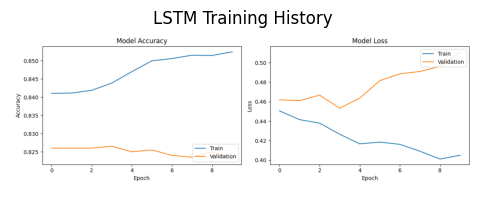

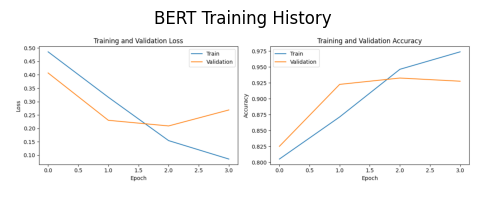


LSTM Classification Report:
LSTM Model Evaluation
Test Loss: 0.4323
Test Accuracy: 0.8389

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.33      0.01      0.03      1589
Positive (1)       0.84      0.99      0.91      8411

    accuracy                           0.84     10000
   macro avg       0.59      0.50      0.47     10000
weighted avg       0.76      0.84      0.77     10000


Confusion Matrix:
[[  21 1568]
 [  43 8368]]

BERT Classification Report:
BERT Fine-tuned Model Evaluation
Test Loss: 0.2092
Test Accuracy: 0.9325

Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.8909    0.7000    0.7840        70
Positive (1)     0.9391    0.9818    0.9600       330

    accuracy                         0.9325       400
   macro avg     0.9150    0.8409    0.8720       400
weighted avg     0.9307    0.9325    0.9292       400


Confusion Matrix:
[[ 49  21]
 [  6 324]]


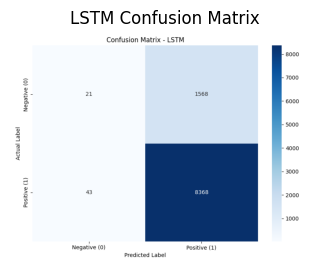

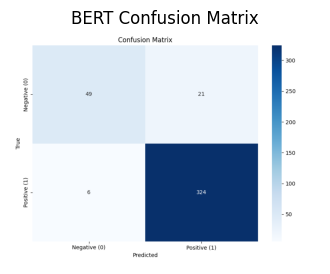


--- Model Performance Summary ---

Bert Classification Report:
BERT Fine-tuned Model Evaluation
Test Loss: 0.2092
Test Accuracy: 0.9325

Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.8909    0.7000    0.7840        70
Positive (1)     0.9391    0.9818    0.9600       330

    accuracy                         0.9325       400
   macro avg     0.9150    0.8409    0.8720       400
weighted avg     0.9307    0.9325    0.9292       400


Confusion Matrix:
[[ 49  21]
 [  6 324]]

Logistic Regression Classification Report:
Logistic Regression Model Evaluation
Accuracy: 0.9312

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.85      0.68      0.76     11422
Positive (1)       0.94      0.98      0.96     61411

    accuracy                           0.93     72833
   macro avg       0.90      0.83      0.86     72833
weighted avg       0.93      0.93      0.93     72833


Confusion Matrix:
[[

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Display LSTM training history
lstm_history_path = os.path.join('models', 'lstm_history.png')
if os.path.exists(lstm_history_path):
    img = Image.open(lstm_history_path)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('LSTM Training History')
    plt.show()
else:
    print('LSTM training history image not found.')

# Display BERT training history
bert_history_path = os.path.join('models', 'bert_history.png')
if os.path.exists(bert_history_path):
    img = Image.open(bert_history_path)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('BERT Training History')
    plt.show()
else:
    print('BERT training history image not found.')

# Display LSTM classification report
lstm_report_path = os.path.join('models', 'lstm_report.txt')
if os.path.exists(lstm_report_path):
    print('\nLSTM Classification Report:')
    with open(lstm_report_path, 'r') as f:
        print(f.read())
else:
    print('LSTM classification report not found.')

# Display BERT classification report
bert_report_path = os.path.join('models', 'bert_report.txt')
if os.path.exists(bert_report_path):
    print('\nBERT Classification Report:')
    with open(bert_report_path, 'r') as f:
        print(f.read())
else:
    print('BERT classification report not found.')

# Display LSTM confusion matrix
lstm_cm_path = os.path.join('models', 'lstm_cm.png')
if os.path.exists(lstm_cm_path):
    img = Image.open(lstm_cm_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('LSTM Confusion Matrix')
    plt.show()
else:
    print('LSTM confusion matrix image not found.')

# Display BERT confusion matrix
bert_cm_path = os.path.join('models', 'bert_cm.png')
if os.path.exists(bert_cm_path):
    img = Image.open(bert_cm_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('BERT Confusion Matrix')
    plt.show()
else:
    print('BERT confusion matrix image not found.')

# Optionally, summarize results for all models
import glob
print('\n--- Model Performance Summary ---')
for report_file in glob.glob(os.path.join('models', '*_report.txt')):
    model_name = os.path.basename(report_file).replace('_report.txt','').replace('_',' ').title()
    print(f'\n{model_name} Classification Report:')
    with open(report_file, 'r') as f:
        print(f.read())